In [37]:
%load_ext autoreload
%autoreload 2

from single_cell_analysis.datasets import sciplex

from pathlib import Path

import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc

from geomloss import SamplesLoss
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.1 pandas==1.2.2 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3


In [12]:
# change this path with the path you have sciplex dataset
data_path = Path('/home/yavuz/data/sciplex')
device = torch.device('cpu')
sinkhorn_geomloss = SamplesLoss(loss="sinkhorn", scaling=0.9, p=1, debias=True).to(device)

In [5]:
sciplex2 = sciplex.SciPlex2(data_path / 'sciplex2', preprocess=True).dataset

In [44]:
sciplex2.shape

(18049, 35915)

In [26]:
def extract_sets_from_perturbations(dataset, group_by:list=['perturbation_raw']):
    set_labels = []
    set_values = []
    for group, indices in dataset.obs.groupby(group_by).indices.items():
        set_labels.append(group)
        set_values.append(dataset[indices])
    return set_labels, set_values

In [27]:
set_labels, set_values = extract_sets_from_perturbations(sciplex2)

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [34]:
sinkhorn_matrix = sinkhorn_distances_among_sets(set_values)

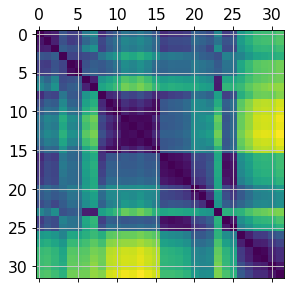

In [36]:
plt.matshow(sinkhorn_matrix)

In [32]:
def sinkhorn_distances_among_sets(sets):
    pairs = torch.combinations(torch.arange(len(sets)), 2)
    distance_matrix = torch.zeros((len(sets),len(sets)))
    for pair in pairs:
        dist = sinkhorn_geomloss(torch.from_numpy(sets[pair[0]].obsm['X_umap']), torch.from_numpy(sets[pair[1]].obsm['X_umap']))
        distance_matrix[pair[0], pair[1]] = dist
        distance_matrix[pair[1], pair[0]] = dist    
    return distance_matrix


In [42]:
import umap
def plot_embeddings_from_distance_matrix(distance_matrix, labels=None):
    umap_ = umap.UMAP(metric='precomputed')
    umap_.fit(distance_matrix.numpy())
    embeddings = umap_.transform(distance_matrix.numpy())
    # treat = np.array([c[0] for c in comb])
    # dose = np.array([c[1] for c in comb])
    # treat_dose = np.array([t + '_' + str(d) for t, d in zip(treat,dose)])
    # for t in np.unique(treat):
    # sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=treat)
    sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1])
    plt.title('Embeddings for treatment distributions')    

/home/yavuz/miniconda3/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


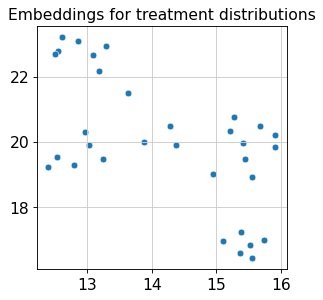

In [43]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix)